# Mount Mansfield Snowpack Data

In [86]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math as m
from scipy import stats
import statsmodels.api as sm

Load functions for analysis

In [90]:
%run /Users/paulnicknish/Desktop/newEnglandSnowpack/research/analysisFunctions.ipynb

In [88]:
# Mansfield Data

# option to use either the data downloaded from NOAA directly, or the processed data from the Mansfield website

dataChoice = 'web' # 'web' or 'noaa'

if dataChoice=='noaa':
    dataPath = '/Users/paulnicknish/Desktop/NewEnglandSnowpack/research/mansfield/1954Through2024.csv'
    # Read in the data
    data = pd.read_csv(dataPath)

    dates = data.DATE.to_numpy()
    snowDepth = data.SNWD.to_numpy()
    
elif dataChoice=='web':
    dataPath = '/Users/paulnicknish/Desktop/newEnglandSnowpack/research/mansfield/mansfieldWebsiteData_through2024.csv'
    # Read in the data
    data = pd.read_csv(dataPath)
    snowDepth = [np.append(data.loc[i].to_numpy()[1:],np.zeros(62)).astype(float) for i in range(len(data.index))]

In [4]:
# Find the indices in the data corresponding to each year
    # we want to track winter seasons, thus the year will be defined from Sept to Sept

lastYearInClim = 2024
startingYear = 1955

yearRange = np.arange(startingYear,lastYearInClim+1)

if dataChoice=='noaa':
    indicesByYear = findYearIndices(startingYear,lastYearInClim,dates)

In [5]:
# Select the snow depth in each year

if dataChoice=='noaa':
    snowDepthByYears = []
    datesByWinter = []

    for iyear in indicesByYear:
        snowDepthInYear = snowDepth[iyear]
        snowDepthByYears = snowDepthByYears + [snowDepthInYear]

        datesByWinter = datesByWinter + [dates[iyear]]

    # Turn calendar date into day of year (with Sept 1 = day 1)
    for iy in range(len(datesByWinter)):
        for iday in range(len(datesByWinter[iy])):

            datesByWinter[iy][iday] = dayOfYearAccountingForLeapYear(datesByWinter[iy][iday])+122

            if datesByWinter[iy][iday]>366 and datesByWinter[iy][iday] != datesByWinter[iy][-1]:
                datesByWinter[iy][iday] = datesByWinter[iy][iday]-366

            # if datesByWinter[iy][-1]==365: # March 1 is always the 61st day of the year, Feb 29 is day 60 in leap years
            #     datesByWinter[iy][datesByWinter[iy]>=60+121] = datesByWinter[iy][datesByWinter[iy]>=60+121] + 1
elif dataChoice=='web':
    snowDepthByYears = snowDepth[:-1]
    datesByWinter = [np.arange(1,367) for i in range(len(snowDepthByYears))]

In [6]:
# Calculate the average over the years

if dataChoice=='noaa':
    dayAverageSnowDepth = []
    for day in range(1,367):
        runningListForMean = []
        for iy in range(len(datesByWinter)):
            if day in datesByWinter[iy]:
                # Find the index of that day in datesByWinter[iy]
                indexOfParticularDay = np.nonzero(datesByWinter[iy] == day)[0][0]
                runningListForMean = runningListForMean + [snowDepthByYears[iy][indexOfParticularDay]]
        dayAverageSnowDepth = dayAverageSnowDepth + [np.nanmean(np.array(runningListForMean))]

elif dataChoice=='web':
    dayAverageSnowDepth = snowDepth[-1]

Text(0.5, 1.0, 'Mount Mansfield Snowpack')

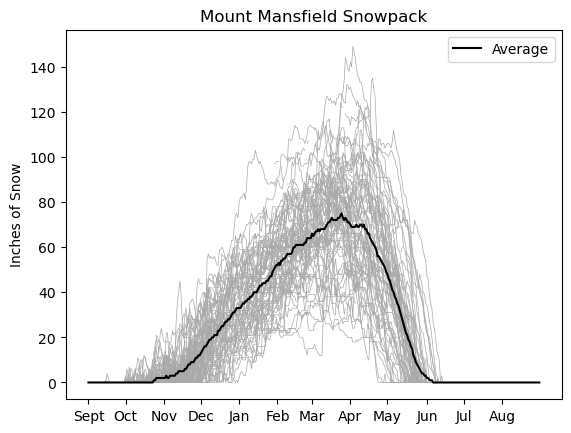

In [61]:
### Highlight a particular year (give the year in the spring of the winter season) ###
#yearHighlight = input('Enter year')
yearHighlight = 2019

# Put all of these years on a plot
for i in range(len(snowDepthByYears)):
    plt.plot(datesByWinter[i],snowDepthByYears[i],c='darkgray',linewidth = .5)

# Plot highlighted year
indOfHigherYear = np.nonzero(yearRange == yearHighlight)[0][0]
#plt.plot(datesByWinter[indOfHigherYear],fillInNans(snowDepthByYears[indOfHigherYear]),label = '{}-{}'.format(yearHighlight-1,yearHighlight))

# Plot the average
plt.plot(range(1,367),dayAverageSnowDepth,label='Average',c='k')
plt.legend()

plt.xticks([dayOfYear('2000-09-01')+122-366, dayOfYear('2000-10-01')+122-366,
            dayOfYear('2000-11-01')+122-366, dayOfYear('2000-12-01')+122-366,
            dayOfYear('2001-01-01')+122, dayOfYear('2001-02-01')+122,
            dayOfYear('2001-03-01')+122, dayOfYear('2001-04-01')+122,
            dayOfYear('2001-05-01')+122, dayOfYear('2000-06-01')+122,
            dayOfYear('2000-07-01')+122, dayOfYear('2000-08-01')+122],
           ['Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']);

plt.ylabel('Inches of Snow')

plt.title('Mount Mansfield Snowpack')

# Look at Changes in variability using FFT

In [8]:
# First, replace all the nans in the data using linear interpolation
snowDepthByYears_noNAN = [fillInNans(year) for year in snowDepthByYears]

In [9]:
# Calculate the amplitudes of the Fourier Components for each year
snowDepthByYearsAmps = [ampFromFFT(year)[0] for year in snowDepthByYears_noNAN]

In [10]:
# Calculate the total harmonic distortion of each year
snowDepthByYearsTHD = np.array([THD(year) for year in snowDepthByYearsAmps])

Text(0.5, 0, 'Year')

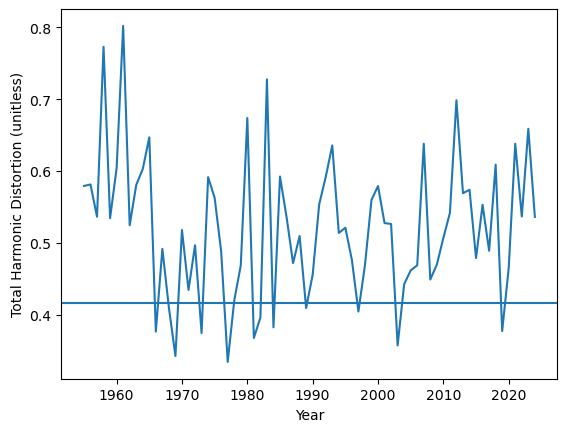

In [11]:
yearRange = yearRange
plt.plot(yearRange,snowDepthByYearsTHD)

# plot the average
plt.axhline(THD(ampFromFFT(dayAverageSnowDepth)[0]))

plt.ylabel('Total Harmonic Distortion (unitless)')
plt.xlabel('Year')

0.014182118060535407


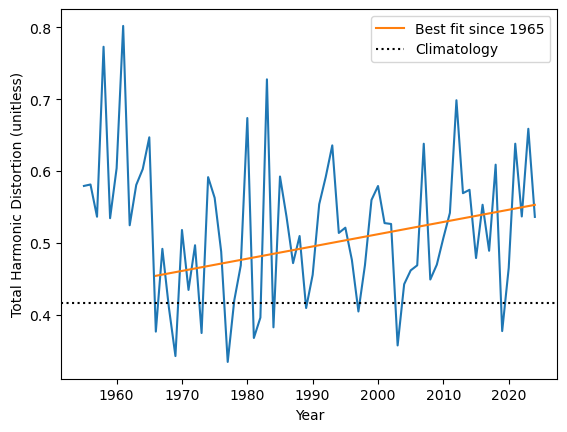

In [66]:
startYearForSlope = 1965
coeffs = np.polyfit(yearRange[yearRange>startYearForSlope],snowDepthByYearsTHD[yearRange>startYearForSlope],1)
plt.plot(yearRange,snowDepthByYearsTHD)
plt.plot(yearRange[yearRange>startYearForSlope],yearRange[yearRange>startYearForSlope]*coeffs[0] + coeffs[1],label='Best fit since {}'.format(startYearForSlope))

slope, intercept, r_value, p_value, std_err = stats.linregress(yearRange[yearRange>startYearForSlope],snowDepthByYearsTHD[yearRange>startYearForSlope])

print(p_value)

# add line for average
plt.axhline(THD(ampFromFFT(dayAverageSnowDepth)[0]),label='Climatology',linestyle=':',color='k')


plt.ylabel('Total Harmonic Distortion (unitless)')
plt.xlabel('Year')

plt.legend()

In [110]:

xxx = np.random.random(10)
yyy = np.random.random(10)
slope, intercept, r_value, p_value, std_err = stats.linregress(yearRange[yearRange>startYearForSlope],snowDepthByYearsTHD[yearRange>startYearForSlope])

confidence_interval = 2.58*std_err

In [111]:
p_value

0.17711180499204168

In [114]:
import numpy as np, statsmodels.api as sm

nsample = 100
x = np.linspace(0, 10, nsample)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

X = sm.add_constant(X)
y = np.dot(X, beta) + e

mod = sm.OLS(yyy, xxx)
res = mod.fit()
print(res.conf_int(0.01))   # 99% confidence interval

[[-0.20009558  1.34596074]]


In [115]:
slope+confidence_interval

0.004093535321988234

In [116]:
res

# Other things to look at

Text(0, 0.5, 'Inches')

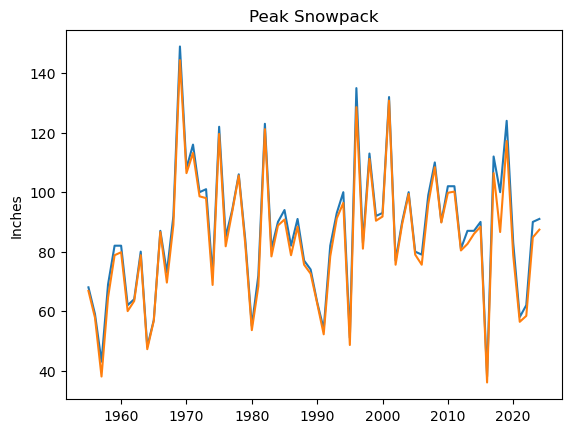

In [43]:
## Look at max snowpack overtime
maxSnowPackByWinter = [np.nanmax(winterSnow) for winterSnow in snowDepthByYears]

## Also look at max snowpack when a 5 day moving average is applied
maxSnowPackByWinter_movAvg = [np.nanmax(movingaverage(winterSnow,5)) for winterSnow in snowDepthByYears]


plt.plot(yearRange,maxSnowPackByWinter)
plt.plot(yearRange,maxSnowPackByWinter_movAvg)
plt.title('Peak Snowpack')
plt.ylabel('Inches')

In [94]:
# Look at median and IQR
median,iqr = medIQR(np.array(maxSnowPackByWinter))
print('{} -- {} -- {}'.format(iqr[0],median,iqr[1]))

print((iqr[1]-iqr[0])/median)

73.25 -- 87.0 -- 100.0
0.3074712643678161


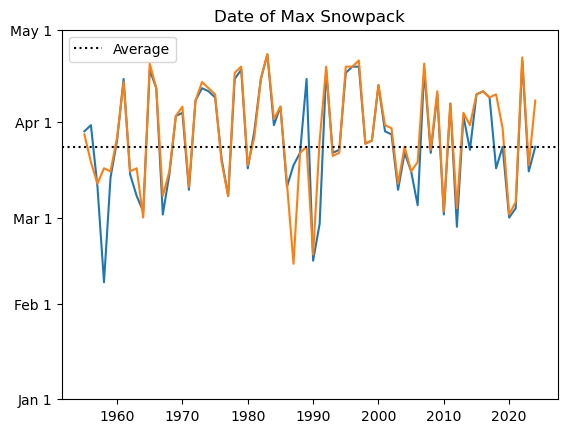

In [42]:
## Look at date of peak snowpack
dateOfPeak = [datesByWinter[i][np.nanargmax(snowDepthByYears[i])] for i in range(len(snowDepthByYears))]
plt.plot(yearRange,dateOfPeak)

## Also look at date of peak snowpack when a 5 day moving average is applied
dateOfPeak_movAvg = [datesByWinter[i][np.nanargmax(movingaverage(snowDepthByYears[i],5))] for i in range(len(snowDepthByYears))]
plt.plot(yearRange,dateOfPeak_movAvg)

dateOfPeakAvg = np.nanargmax(dayAverageSnowDepth)
plt.axhline(dateOfPeakAvg,label='Average',c='k',linestyle=':')

plt.yticks([dayOfYear('2001-01-01')+122, dayOfYear('2001-02-01')+122,
            dayOfYear('2001-03-01')+122, dayOfYear('2001-04-01')+122,
            dayOfYear('2001-05-01')+122],
           ['Jan 1','Feb 1','Mar 1','Apr 1','May 1']);

plt.title('Date of Max Snowpack')
plt.legend()

Text(0.5, 0, 'Year')

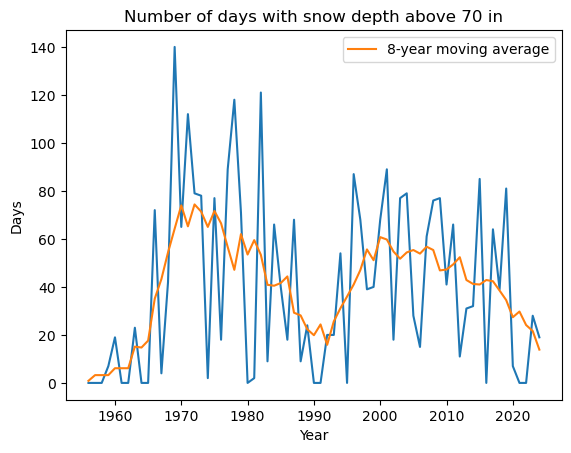

In [60]:
# Number of days that the VT Backcountry is "in"
# The bc is considered "in" if the snow depth at Mansfield is above the bcThresh

bcThresh = 70


daysWithBCIn = [len(winterSnow[winterSnow>=bcThresh]) for winterSnow in snowDepthByYears]
plt.plot(yearRange[1:],daysWithBCIn[1:])

windowSize = 8
a = movingaverage(daysWithBCIn[1:],windowSize)
plt.plot(yearRange[1:],a,label='{}-year moving average'.format(windowSize))

plt.title('Number of days with snow depth above {} in'.format(bcThresh))

plt.legend()
plt.ylabel('Days')
plt.xlabel('Year')

# Scratch work

In [427]:
# Amplitude Spectrum from FFT
sampleFrequency = 366 # samples per year
timeOverYear = np.arange(1,367)
freq = np.arange(0,sampleFrequency,sampleFrequency/len(timeOverYear))
N = len(dayAverageSnowDepth) # Number of samples

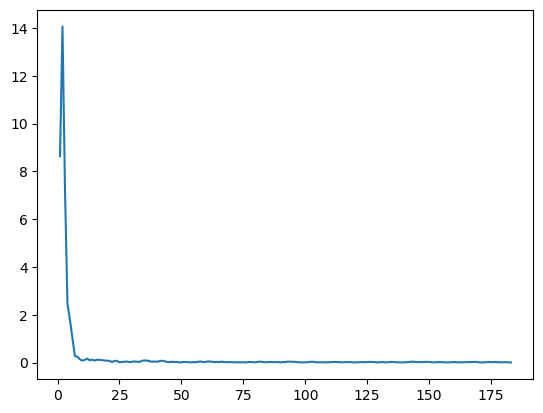

In [428]:
# Amplitude Spectrum from FFT
xk = abs(np.fft.fft(dayAverageSnowDepth))/N; # Two-sided amplitude
xk = xk[0:int(N/2)]; # One-sided
xk[1:-2] = 2*xk[1:-2]; # Double values except for DC and Nyquist

plt.plot(freq[1:int(N/2+1)],xk)

In [304]:
indOfHigherYear

86

In [435]:
testYear = snowDepthByYears[50]
np.nansum(testYear)/366

1.226775956284153

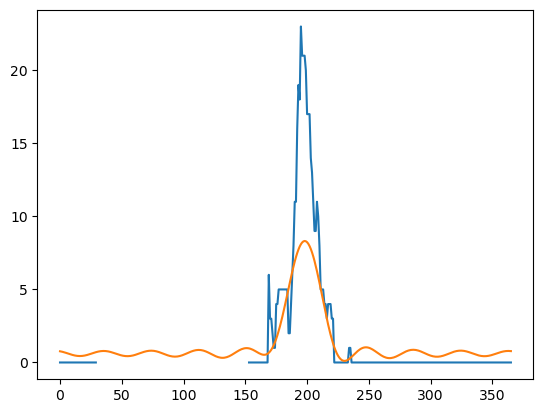

In [477]:
a = np.fft.fft(fillInNans(testYear))
b = np.fft.fft(fillInNans(testYear))
a[0] = 0
K = 180
b[10:] = 0


#plt.plot(np.fft.ifft(a))
plt.plot(testYear)
plt.plot(np.fft.ifft(b))

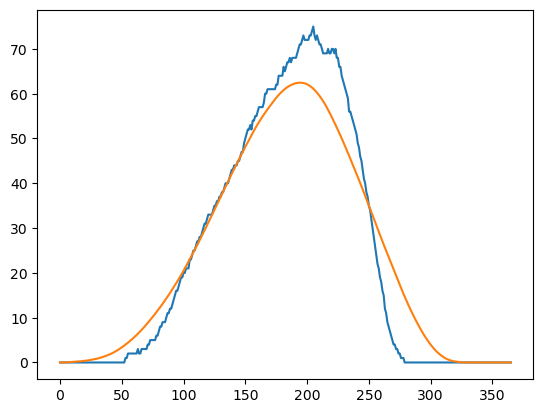

In [81]:
plt.plot(dayAverageSnowDepth)
plt.plot(movingaverage(dayAverageSnowDepth,100))

In [82]:
noMvAvg = THD(ampFromFFT(dayAverageSnowDepth)[0])
smoothAvg = movingaverage(dayAverageSnowDepth,100)
withMvAvg = THD(ampFromFFT(smoothAvg)[0])

In [83]:
withMvAvg

0.24442919380878267

In [84]:
noMvAvg

0.4157617758469518